<a href="https://colab.research.google.com/github/shivamishu/cmpe255/blob/main/K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implement various clustering algorithms in colabs

**Shivam Shrivastav**

#K-Means

## Data Set 
The data set I used for the assignment is "User Activity Recognition" available on Kaggle:  
https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones  
The data was collected using a smartphone. Each user, who contributed the data, performed the follwing 6 acitivities wearing smartphone on their waist: LAYING, SITTING, STANDING, WALKING,WALKING_DOWNSTAIRS, WALKING_UPSTAIRS.

## Business Objective 
Find the activity being performed by the user to help decide mobile application which action needs to be taken according to the user's activity. For example, when the application needs to trigger an API call to store user's activity and decide the next set of activities to be suggessted.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import plotly.io as pio
pio.renderers.default = 'colab'

import pdb
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd 'drive/MyDrive'

/content/drive/MyDrive


In [ ]:
train = pd.read_csv('train.csv')
train = train.sample(frac=1)
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
2047,0.322444,-0.036410,-0.073435,-0.256101,-0.155676,-0.169324,-0.285634,-0.146045,-0.121873,-0.158359,-0.244177,-0.078938,0.296522,0.156763,0.636981,-0.129369,-0.721620,-0.860921,-0.686919,-0.348815,-0.259915,-0.021509,0.267200,0.344746,0.010604,-0.624723,0.463962,-0.168330,0.063355,-0.215506,0.118683,0.138268,0.029630,-0.419169,0.252147,-0.140040,0.048626,-0.573898,0.026910,-0.043788,...,0.112286,-0.904762,-0.035764,0.086890,-0.190834,-0.575236,-0.468125,-0.460987,-0.544634,-0.927967,-0.575236,-0.848571,-0.588014,0.398971,-0.846154,-0.275748,-0.160977,-0.547147,-0.800349,-0.819872,-0.790406,-0.854811,-0.915550,-0.800349,-0.980014,-0.790238,0.086815,-0.904762,0.043422,-0.429053,-0.775562,-0.551726,0.549659,0.973922,0.105285,-0.625280,0.333168,-0.091014,11,WALKING_UPSTAIRS
4599,0.228501,-0.062745,-0.067703,-0.892708,-0.738275,-0.900069,-0.899030,-0.772555,-0.908323,-0.839325,-0.496622,-0.656404,0.742426,0.455881,0.819410,-0.852941,-0.993335,-0.982259,-0.991789,-0.913131,-0.855379,-0.920467,-0.072670,-0.399335,0.111717,-0.076572,0.026839,0.132614,-0.360926,-0.551328,0.676203,-1.000000,1.000000,-0.083367,0.197448,-0.302438,-0.032621,0.030217,0.078648,-0.742886,...,-0.608867,-1.000000,-0.521107,0.454110,0.134304,-0.898708,-0.855556,-0.861836,-0.848925,-0.997464,-0.898708,-0.989260,-0.931513,-0.158243,-1.000000,-0.416587,0.012502,-0.318974,-0.931591,-0.912745,-0.921412,-0.902621,-0.974984,-0.931591,-0.996615,-0.924088,-0.347514,-1.000000,-0.158121,0.411046,0.112776,0.049594,0.297818,-0.079556,0.055665,0.653832,-0.327370,-0.683770,22,LAYING
5913,0.270153,-0.016308,-0.100933,-0.996244,-0.991705,-0.996808,-0.996551,-0.992283,-0.997007,-0.941710,-0.567275,-0.816271,0.849201,0.690751,0.850936,-0.995226,-0.999966,-0.999954,-0.999877,-0.996720,-0.993303,-0.995484,-0.759366,-0.627118,-0.484375,0.190251,-0.023321,0.090403,-0.218773,0.246893,-0.018683,-0.024435,0.371534,0.465688,-0.265462,0.230830,-0.106870,-0.075872,-0.354979,-0.062755,...,-1.000000,-0.936508,0.495173,-0.745488,-0.939613,-0.994361,-0.995277,-0.994291,-0.995436,-0.999082,-0.994361,-0.999965,

In [ ]:
test = pd.read_csv('test.csv')
test = test.sample(frac=1)
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
2405,0.253746,-0.034600,-0.092834,-0.934039,-0.707954,-0.856106,-0.945386,-0.755095,-0.865998,-0.852298,-0.382056,-0.676309,0.757280,0.528437,0.790783,-0.866676,-0.997440,-0.982156,-0.988578,-0.962525,-0.882291,-0.882076,-0.193786,-0.226601,-0.057297,-0.420650,0.369222,-0.249805,0.194667,-0.068980,-0.091807,0.018261,0.521516,0.149402,-0.159495,0.046771,0.176828,0.778133,-0.158433,0.284513,...,-0.531824,-1.000000,0.072502,-0.193528,-0.580145,-0.724388,-0.593826,-0.599948,-0.620693,-0.887798,-0.724388,-0.918637,-0.856387,0.108031,-1.000000,-0.453948,-0.126077,-0.516906,-0.861895,-0.856994,-0.845002,-0.846476,-0.920312,-0.861895,-0.989148,-0.824288,-0.066157,-1.000000,-0.092721,0.054377,-0.214122,0.036238,-0.025913,0.710765,-0.887907,-0.579113,0.386246,-0.020448,20,STANDING
1834,0.321817,-0.022188,-0.124471,-0.261231,0.434018,-0.360139,-0.289943,0.385906,-0.368025,-0.231750,0.113715,-0.280215,0.147480,-0.075165,0.539623,-0.042381,-0.725430,-0.604546,-0.812772,-0.335588,-0.037180,-0.435894,0.563435,0.425513,-0.063003,-0.254155,0.011737,0.122650,0.126155,-0.339393,0.197110,0.089021,0.107510,-0.253611,0.171647,-0.006261,-0.180303,-0.038119,0.160339,0.026430,...,0.225102,-0.904762,-0.064720,-0.353614,-0.715986,-0.417928,-0.257684,-0.275306,-0.248606,-0.823849,-0.417928,-0.709120,-0.405723,0.520972,-1.000000,-0.332472,-0.045935,-0.391894,-0.664048,-0.692127,-0.670532,-0.673848,-0.902424,-0.664048,-0.943367,-0.592716,0.332324,-0.904762,-0.003795,-0.046321,-0.324093,-0.667188,-0.161848,-0.948680,0.811760,-0.622568,0.358864,0.016928,13,WALKING_UPSTAIRS
2035,0.217992,0.010592,-0.137842,-0.315713,-0.295836,-0.391197,-0.402918,-0.292246,-0.396037,0.010986,-0.207541,-0.393297,0.386812,0.362933,0.499782,-0.284729,-0.763839,-0.901894,-0.829139,-0.571251,-0.422672,-0.469921,0.173131,0.332537,-0.178837,-0.369829,0.246889,-0.200677,0.297475,-0.161061,0.087626,0.062938,0.126946,-0.402001,0.189063,0.097998,-0.200074,-0.420203,-0.178909,0.036658,...,0.203915,-0.904762,0.104987,-0.357867,-0.703813,-0.702265,-0.612023,-0.611400,-0.607445,-0.899253,-0.702265,-0.920905,-0

In [ ]:
X_train = train.iloc[:,:-2]
Y_train = train.Activity
train = train.drop(['Activity', 'subject'], axis=1)
print(Y_train.shape)

(7352,)


In [ ]:
X_test = test.iloc[:,:-2]
Y_test = test.Activity
test = test.drop(['Activity', 'subject'], axis=1)
print(Y_test.shape)

(2947,)


In [ ]:

# Plotting data
label_counts = Y_train.value_counts()
label_counts
# Get colors
n = label_counts.shape[0]
colormap = get_cmap('summer')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Create plot
data = go.Bar(x = label_counts.index,
              y = label_counts,
              marker = dict(color = colors))

layout = go.Layout(title = 'User Activity Label Distribution',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

### K-Means Psuedo Algorithm
Randomly assign initial clusters

Assgin each sample to its nearest centroid

Get new centroids by averaging out the assignment.

Run the K-means algorithm

### User Activity K-Means Clustering using Scikit-Learn

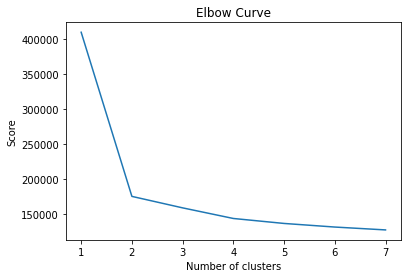

In [ ]:
# Using the elbow method to calculate the k-cluster value for clustering.  
# Calculating the "Sum of Square Errors" (SSE) to find the appropriate value of "K"
from sklearn.cluster import KMeans
SSE = []
for i in range(1,8):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=1500,n_init=10,random_state=0)
    kmeans.fit(train)
    SSE.append(kmeans.inertia_)
plt.plot(range(1,8),SSE)
plt.title('Elbow Curve')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.show()

<!-- Results in the above graph shows that the score levels gradually becomes constant after ~6 clusters -->



In [ ]:
# Results in the above graph shows that the score levels gradually becomes constant after ~6 clusters

# Applying K-Means for 6 clusters
Kmean = KMeans(n_clusters=6, init= 'k-means++')
Kmean.fit(train)
c_labels = Kmean.labels_
df = pd.DataFrame({'clust_label': c_labels, 'orig_label': np.array(Y_train)})
ct = pd.crosstab(df['clust_label'], df['orig_label'])
cluster_labels = kmeans.fit_predict(train)
centers = kmeans.cluster_centers_
y_clust = kmeans.predict(train)
display(ct)

orig_label,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
clust_label,,,,,,
0,10,1,0,587,134,814
1,1233,49,0,0,0,0
2,0,0,0,555,627,215
3,164,304,412,0,0,0
4,0,932,962,0,0,0
5,0,0,0,84,225,44


### User Activity K-Means Clustering using Tensorflow

In [ ]:
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
k_means_placeholder = tf.placeholder(tf.float32, shape=(7352, 561))
updated_centroids = tf.placeholder(tf.float32, shape=(6, 561))

In [ ]:
# Generate initial centroids
num_samples = tf.shape(k_means_placeholder)[0]
random_indices = tf.random_shuffle(tf.range(0, num_samples))
centroid_indices = tf.slice(random_indices, [0], [6])
init_centroids = tf.gather(k_means_placeholder, centroid_indices)

In [ ]:
# Assign to the nearest centroid
expand_samples = tf.expand_dims(k_means_placeholder, 0)
expand_centroid = tf.expand_dims(updated_centroids, 1)
distances = tf.reduce_sum(tf.square(tf.subtract(expand_samples, expand_centroid)), 2)
nearest_index = tf.argmin(distances, 0)

In [ ]:
# update the centroids
def update_centroid(samples, nearest_index, num_clusters):
  """
  samples: tensor, (num_samples, num_features)
  nearest_index: tensor, (num_samples)
  num_clusters: int
  """
  
  nearest_index = tf.to_int32(nearest_index)
  partitions = tf.dynamic_partition(samples, nearest_index, num_clusters)
  new_centroids = tf.concat([tf.reduce_mean(partition, 0, keep_dims=True) for partition in partitions], axis=0)
  
  return new_centroids, nearest_index

In [ ]:
# updating the centroids
updated_centroid = update_centroid(k_means_placeholder, nearest_index, 6)
print(updated_centroid)

Instructions for updating:
Use `tf.cast` instead.
(<tf.Tensor 'concat:0' shape=(6, 561) dtype=float32>, <tf.Tensor 'ToInt32:0' shape=(7352,) dtype=int32>)


In [ ]:
with tf.Session() as sess:
  centroids = sess.run(init_centroids, feed_dict={k_means_placeholder:train})
  for i in range(0, 300):
    centroids,nearest_index = sess.run(updated_centroid, feed_dict={k_means_placeholder:train,updated_centroids:centroids})

[5 4 4 ... 0 5 1]
['WALKING' 'LAYING' 'LAYING' ... 'SITTING' 'WALKING_DOWNSTAIRS'
 'WALKING_DOWNSTAIRS']


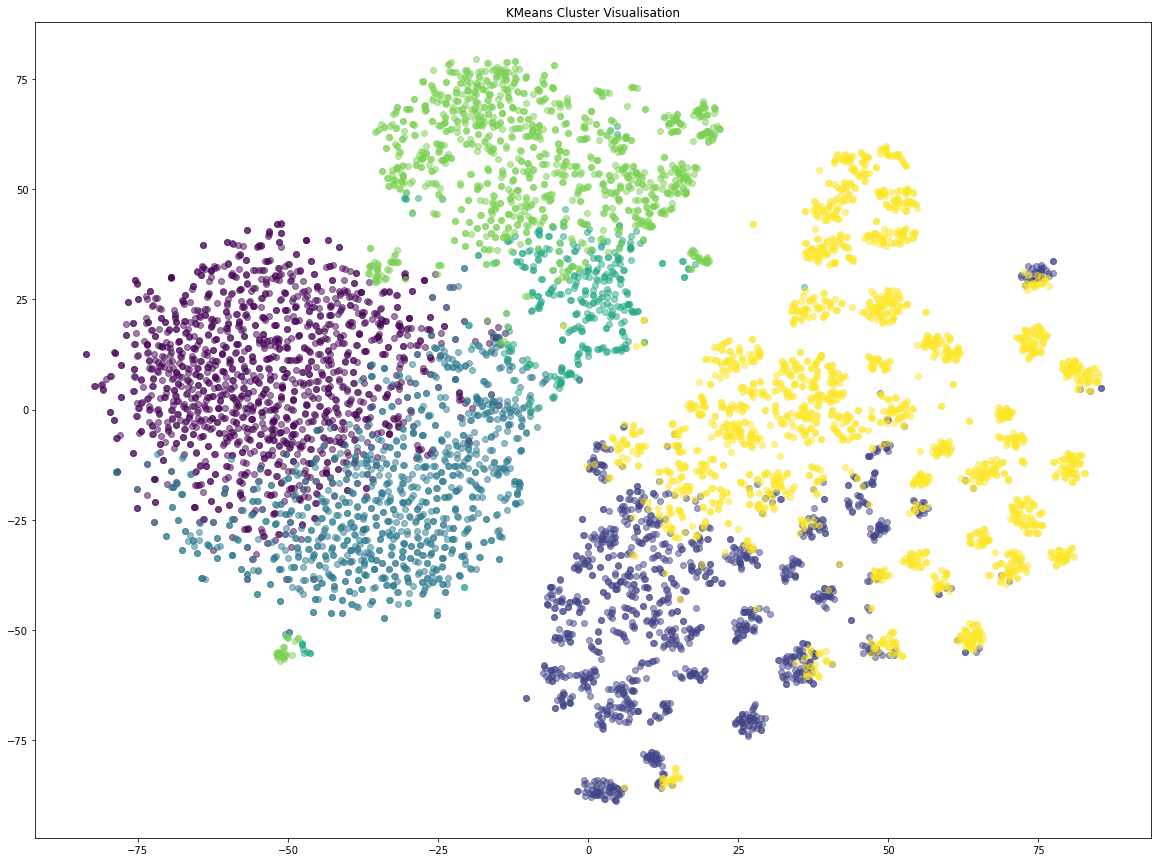

Activity,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
row_0,,,,,,
0,0,789,730,0,0,0
1,0,0,0,372,726,159
2,4,397,641,0,0,0
3,294,51,3,0,0,0
4,1104,48,0,0,0,0
5,5,1,0,854,260,914


In [ ]:
print(nearest_index)
print(Y_train.values)

tsne_data = train.copy()
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)

# Get colors
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

plt.figure(figsize=(20,15))

for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (nearest_index==i)
    plt.scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

plt.title('KMeans Cluster Visualisation')
plt.show()
    
pd.crosstab(nearest_index, Y_train)

### Findings

1) Here, we see that '**walking**' activities are separated out from the other passive activities. 
**Cluster 1 and Cluster 5 are filled with 'walking'** activities, while the rest of the clusters represent the passive activities.

2)**Cluster 5 has more of 'walking upstairs' and 'walking' **inside it, while majority of the samples of **cluster 1 are 'walking downstairs'**. This means 'walking downstairs' are easier to separate out from the other two, while the 'walking' and 'walking upstair' are very easy to get mixed.

3) **Cluster 3 and 4** are filled with **'laying'**, and **cluster 0 and 2** are filled with **'sitting' and 'standing'**. Laying is easier to be distinguished from the other two. 
With this, it seems that the k-means algorithm has difficulites identifying 'sitting' and 'standing', which is well accepted as we need to identify walking activity majorly for the business usecase.



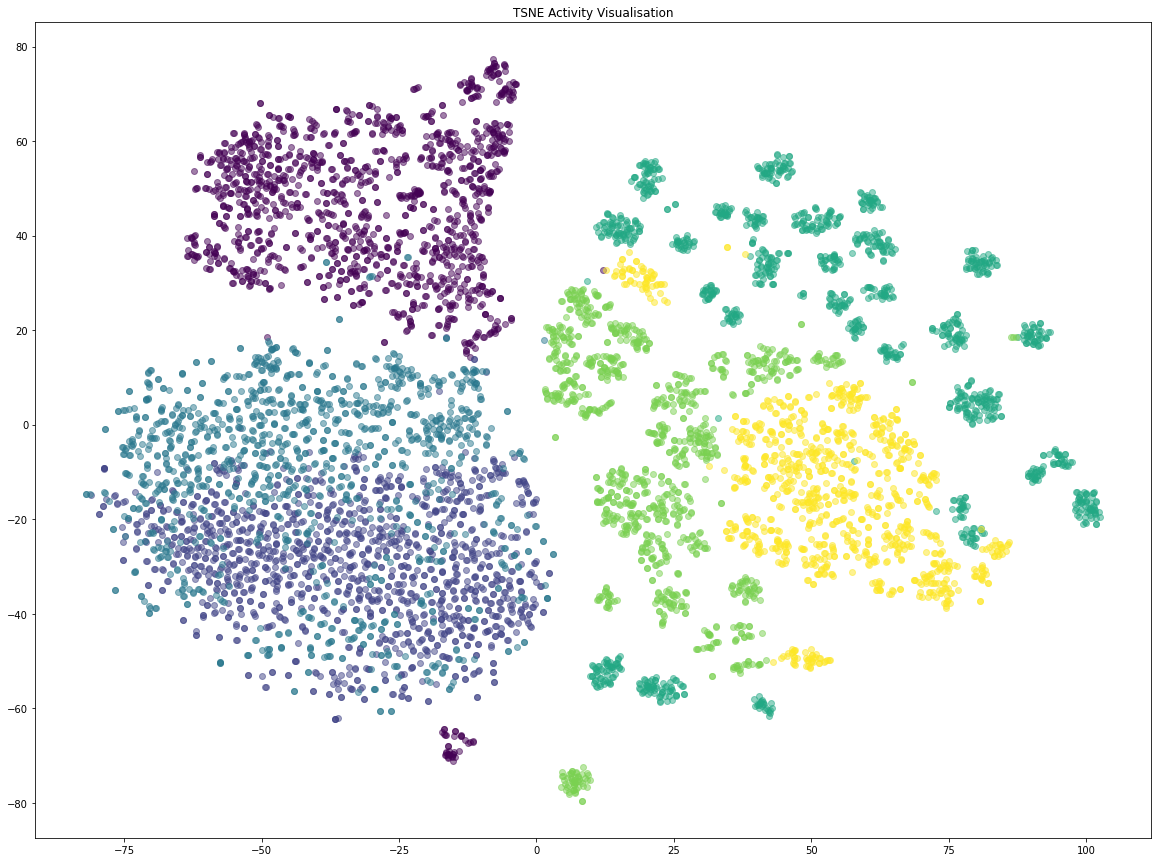

In [ ]:
### Plotting Activities
# Get colors
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

plt.figure(figsize=(20,15))

for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (Y_train==group).values
    plt.scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
plt.title('TSNE Activity Visualisation')
plt.show()